In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import numpy as np
from scipy.optimize import curve_fit
import glob

import images_library


def line(x, m, q): 
    return m*x+q

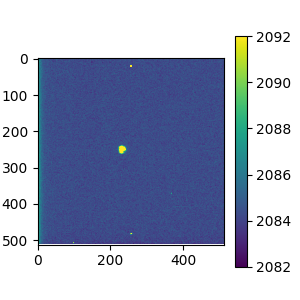

In [2]:
#Find the mean dark
#darkFiles = glob.glob(f"20221102_Flash/2022_11_03_flash_1mm/sat/*buio*.TIF") #per le misure del 3
darkFiles = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*buio*.TIF")
imArray=images_library.openImage(darkFiles[0])

darkImage=np.zeros((imArray.shape))
for d in darkFiles:
    darkImage += images_library.openImage(d)
    
dark=darkImage/len(darkFiles)
images_library.plotImage(dark, title='', bounds=[2082, 2092])

In [3]:
#per ogni file mi devo far restituire l'immagine e devo mantenere il nome del file, il nome del file deve 
#essere associato alle UM-> dict

#3/11/22
"""
signalGyDict = {'70cGy': [[], [], [0.79, 0.80, 0.80] ], 
                   '300cGy': [[],[], [4.08, 3.99, 4.08]], 
                   '600cGy': [[],[], [6.27, 6.27, 6.18]], 
                   '9Gy': [[],[], [9.66, 9.56, 9.56]], 
                   '12Gy': [[],[], [12.52, 12.52, 12.52]], 
                   '15Gy': [[],[], [14.98, 14.68, 14.68]], 
                   '18Gy': [[],[], [16.93, 17.08, 16.93]],
                   '20Gy': [[],[], [19.13, 19.13, 19.13]], 
                   '23Gy': [[],[], [21.43, 21.43, 21.43]], 
                   }
"""
#4/11/22
signalGyDict = {'07Gy': [[], [], [0.59, 0.62, 0.64] ], 
                   #'3Gy': [[],[], [3.73, 3.73, 3.73]], 
                   '6Gy': [[],[], [5.55, 5.64, 5.64]], 
                   '9Gy': [[],[], [8.90, 8.90, 8.90]], 
                   '12Gy': [[],[], [11.74, 11.55, 11.74]], 
                   '15Gy': [[],[], [14.23, 14.23, 14.08]], 
                   '18Gy': [[],[], [16.93, 16.93, 16.47]],
                   '20Gy': [[],[], [18.16, 18.32, 18.]], 
                   '23Gy': [[],[], [20.93, 20.59, 20.26]], 
                   }


In [4]:
saturationFiles=[]
for k in signalGyDict.keys():
    #f=glob.glob(f"20221102_Flash/2022_11_03_flash_1mm/sat/*%s*.TIF" % k) 
    f=glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*%s*.TIF" %k)
    saturationFiles.append(sorted(f))
saturationFiles=np.array(saturationFiles)
saturationFiles

array([['20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_07Gy_1p_4us_1.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_07Gy_1p_4us_2.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_07Gy_1p_4us_3.TIF'],
       ['20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_6Gy_1p_4us_1.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_6Gy_1p_4us_2.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_6Gy_1p_4us_3.TIF'],
       ['20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_9Gy_1p_4us_1.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_9Gy_1p_4us_2.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_9Gy_1p_4us_3.TIF'],
       ['20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_12Gy_1p_4us_1.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_12Gy_1p_4us_2.TIF',
        '20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_12Gy_1p_4us_3.TIF'],
       ['20221102_Flash/2022_11_04_flash_1mm/sat/f11/e

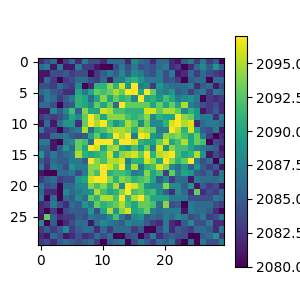

In [5]:
#cenX, cenY= 273, 237 #per le misure del 3
cenX, cenY= 254, 230 #per le misure del 4
x, y = np.ogrid [:len(dark[0]) , :len(dark[1])]
images_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r=15))



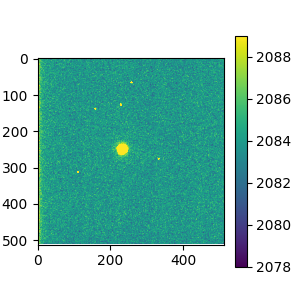

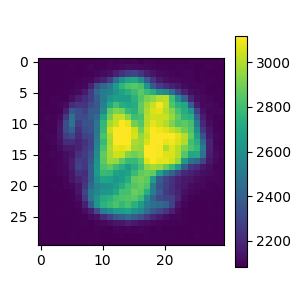

In [6]:
inputfile = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*3Gy*1.TIF")
imArray=images_library.openImage(inputfile[0])
images_library.plotImage(imArray)

images_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r=15))


In [7]:
"""
    This function makes the subtraction of the data images with the dark (mean dark) in a selected ROI. 
    It accepts in input: 
    It returns the dictionary filled with the signal and the standard deviation

"""
def findSignal(dataFiles, darkImage, ROI, outputDict, repetition=3):
    i=0
    for k,i in zip(outputDict.keys(), range(0, len(outputDict.keys()))):
        signalsList = []
        signalErrorsList = []
        for j in range(0, repetition):
            imArray=images_library.openImage(dataFiles[i][j])
            signalsList.append(np.mean(imArray[ROI]-darkImage[ROI]))
            stDev= np.std(imArray[ROI]-darkImage[ROI])
            signalErrorsList.append(stDev/len(np.argwhere(ROI==True)))        
        outputDict[k][0]=signalsList
        outputDict[k][1]=signalErrorsList
        i=i+1    
    return outputDict



"""
    Create lists from dictionary values
"""
def covertDictToArray(inputDict): 
    x =[]
    y =[]
    dy = []
    for k in inputDict.keys():
        y.append(inputDict[k][0])
        dy.append(inputDict[k][1])
        x.append(inputDict[k][2])
    x = [val for sublist in x for val in sublist]
    y = [val for sublist in y for val in sublist]
    dy = [val for sublist in dy for val in sublist]
    outputArray = np.array([x,y,dy])
    return outputArray

def fitLine(x, y, dy):
    opt, pcov = curve_fit(line, x, y, sigma=dy)
    optErr = np.sqrt(pcov.diagonal())
    return opt, optErr

In [8]:
#Scan for different ROI dimensions
dataForDifferentROIs = []
rROI = []
for r in range(5, 50):
    ROI=images_library.defineROI(x, y, cenX, cenY, r)
    signalGyDict = findSignal(saturationFiles, dark, ROI, signalGyDict, repetition=3)
    dataROI=covertDictToArray(signalGyDict)
    dataForDifferentROIs.append(dataROI)
    rROI.append(r)

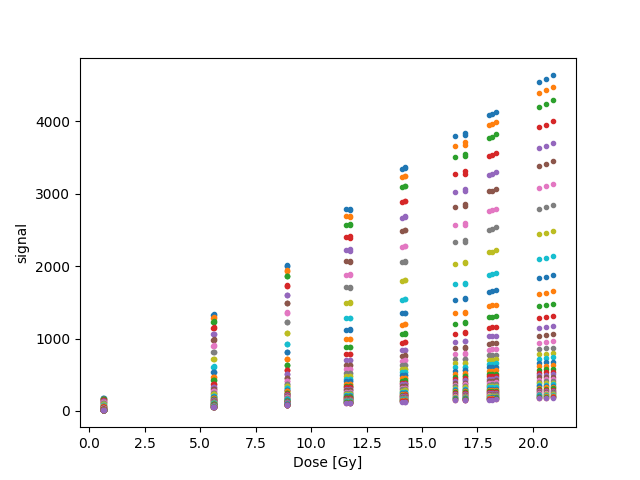

In [13]:

fitParam=[]
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Dose [Gy]")
ax.set_ylabel("signal")


for r in range(0, len(rROI)):
    x = dataForDifferentROIs[r][0]
    y = dataForDifferentROIs[r][1]
    dy = dataForDifferentROIs[r][2]
    ax.errorbar(x, y,yerr=dy, fmt='.')
    dy = np.sqrt((dy/y[-1])**2 + (y/y[-1] * dy[-1]/y[-1])**2)
    y = y/y[-1]
    opt, optErr = fitLine(x, y, dy)
    fitParam.append(opt)
    
    
fitParam=np.array(fitParam)


(array([4., 4., 3., 8., 3., 7., 4., 3., 1., 8.]),
 array([0.00610575, 0.00622173, 0.0063377 , 0.00645368, 0.00656966,
        0.00668563, 0.00680161, 0.00691759, 0.00703356, 0.00714954,
        0.00726552]),
 <BarContainer object of 10 artists>)

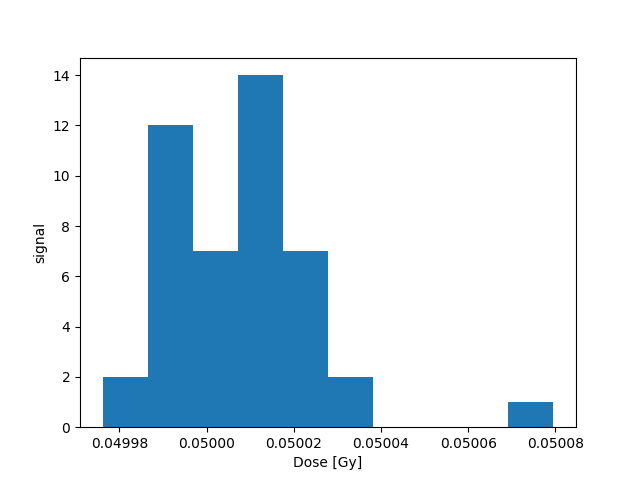

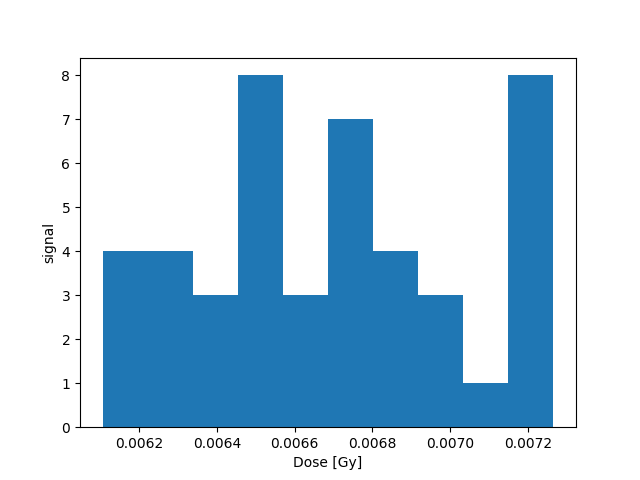

In [16]:

fig, ax = plt.subplots(1,1)
ax.set_xlabel("Dose [Gy]")
ax.set_ylabel("signal")
ax.hist(fitParam[:,0])

fig, ax = plt.subplots(1,1)
ax.set_xlabel("Dose [Gy]")
ax.set_ylabel("signal")
ax.hist(fitParam[:,1])

<ErrorbarContainer object of 3 artists>

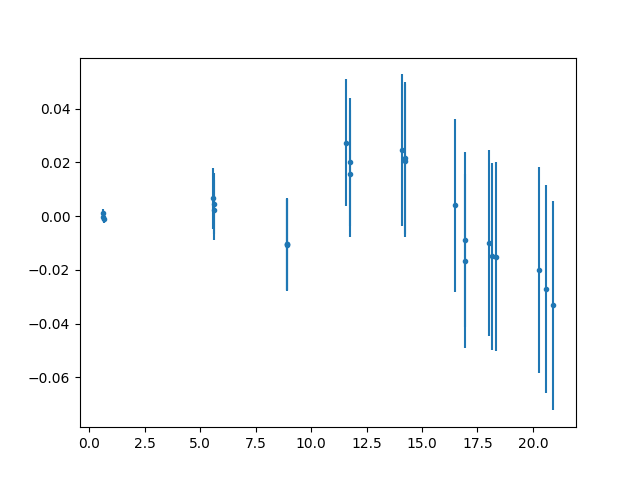

In [15]:
r=5
x = dataForDifferentROIs[r][0]
y = dataForDifferentROIs[r][1]
dy = dataForDifferentROIs[r][2]

dy = np.sqrt((dy/y[0])**2 + (y/y[-1] * dy[-1]/y[-1])**2)
y = y/y[-1]


fig, ax1 = plt.subplots(1,1)
ax.set_xlabel("Dose [Gy]")
ax.set_ylabel("signal")

ax1.errorbar(x, y-line(x,*fitParam[r]), yerr=dy, fmt='.')

